In [1]:
import pathlib

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
import tqdm

from dataset_fetcher import download_uci_adult
from real_games import multi_shapley_values, result_plots, plot_phi

In [2]:
sns.set_style('whitegrid')

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import the adult dataset

In [4]:
data_dir = pathlib.Path('adult_dataset')
train_df, test_df = download_uci_adult(data_dir)
figures_dir = pathlib.Path('figures')
with (figures_dir / '.gitignore').open('w') as gitignore:
    gitignore.write('*.png\n')

# Get feature importances via fitting a boosted trees model

All features performance:
train error: 10.97% | test error: 12.73%



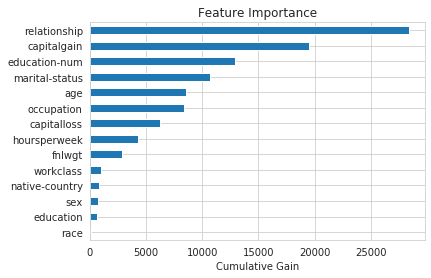

Selected features: ['relationship', 'capitalgain', 'education-num', 'marital-status', 'age']
Selected features performance:
train error: 14.27% | test error: 14.73%


In [5]:
# fit and score the model
model = lgb.LGBMClassifier()
x_train = train_df.drop(columns=['class'])
x_test = test_df.drop(columns=['class'])
y_train = train_df['class']
y_test = test_df['class']
model.fit(x_train, y_train)
print(f'All features performance:'
      f'\ntrain error: {1-sklearn.metrics.accuracy_score(y_train, model.predict(x_train)):.2%}'
      f' | test error: {1-sklearn.metrics.accuracy_score(y_test, model.predict(x_test)):.2%}')
print()

importances = pd.Series(
    model.booster_.feature_importance('gain'), 
    index=train_df.drop(columns=['class']).columns.tolist()
)
importances.sort_values().plot('barh')
plt.xlabel('Cumulative Gain')
plt.title('Feature Importance')
plt.show()

# fit and score the top-features model
features = importances.sort_values(ascending=False).index.tolist()[:5]
print('Selected features:', features)
x_train = x_train.loc[:, features].copy()
x_test = x_test.loc[:, features].copy()
model.fit(x_train, y_train)
print(f'Selected features performance:'
      f'\ntrain error: {1-sklearn.metrics.accuracy_score(y_train, model.predict(x_train)):.2%}'
      f' | test error: {1-sklearn.metrics.accuracy_score(y_test, model.predict(x_test)):.2%}')

# Explaining the model

## For context, plot the distributions of the model's inputs and outputs

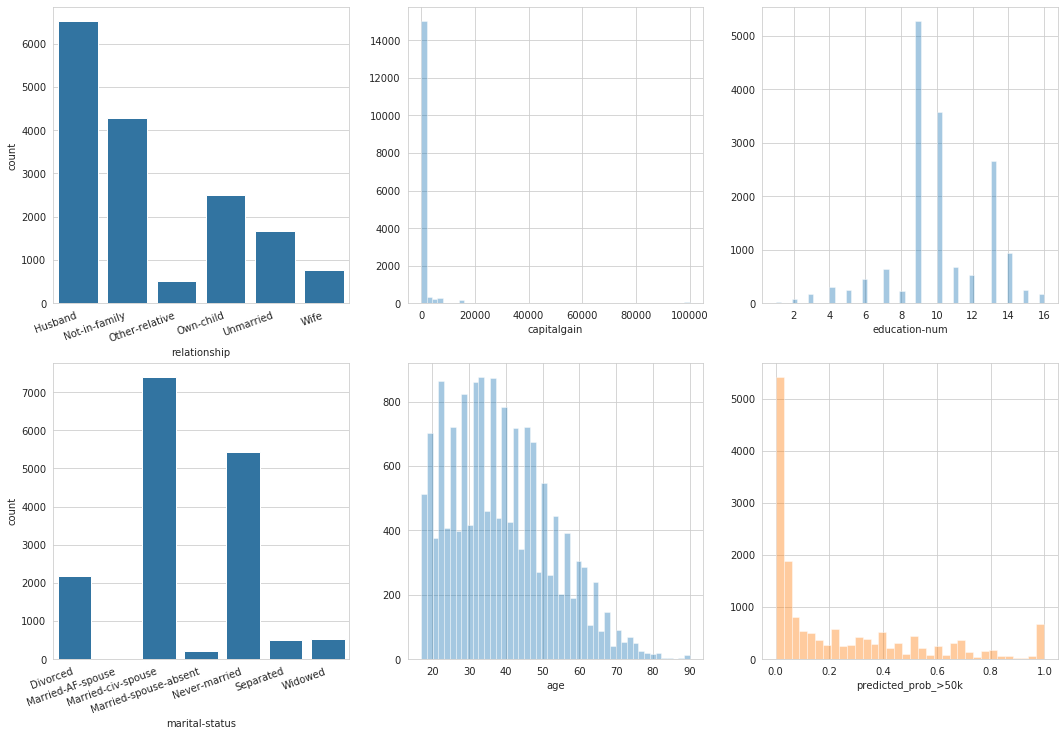

In [6]:
f, axes = plt.subplots(2,3, figsize=(18, 12),)
for i, column_name in enumerate(x_test):
    ax = axes[i//3, i%3]
    if x_test[column_name].dtype.name == 'category':
        sns.countplot(x=column_name, data=x_test, color=sns.color_palette()[0], ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
    else:
        sns.distplot(x_test[column_name], kde=False, ax=ax)
        
y_hat_test = pd.Series(model.predict_proba(x_test)[:, 1], index=x_test.index, name='predicted_prob_>50k')
sns.distplot(y_hat_test, kde=False, ax=axes[1,2], color=sns.color_palette()[1])
f.savefig(figures_dir / 'adult_distributions.png', bbox_inches='tight')
plt.show()

## Let's find a row with low prediction and try to understand why

In [7]:
idx = y_hat_test[y_hat_test.between(0.01, 0.1)].index
low_pred_rows = pd.concat([x_test.loc[idx], y_hat_test.loc[idx]], axis=1)
model_input_idx = 9879
model_input = x_test.iloc[model_input_idx:model_input_idx+1]
display(low_pred_rows.sample(20, random_state=0)
        .style
        .set_caption('Low Score')
        .apply(lambda x: ['background: lightsalmon' if x.name == model_input_idx else '' for i in x], axis=1))

,relationship,capitalgain,education-num,marital-status,age,predicted_prob_>50k
1394,Not-in-family,0,4,Widowed,42,0.0204394
4982,Not-in-family,0,9,Never-married,45,0.0315981
4409,Husband,0,3,Married-civ-spouse,44,0.0732779
1139,Other-relative,0,9,Divorced,39,0.0157809
14322,Not-in-family,0,10,Divorced,37,0.0708782
3138,Own-child,0,13,Never-married,25,0.0116474
5946,Not-in-family,0,12,Never-married,37,0.0806656
8070,Not-in-family,0,6,Never-married,30,0.021523
7243,Not-in-family,0,9,Divorced,39,0.0468092
5310,Not-in-family,0,9,Divorced,43,0.0471651


## Playing n games (one per input)

pre-computing payout functions...


100%|██████████| 16281/16281 [00:01<00:00, 11083.64it/s]


computing shapley values...


100%|██████████| 16281/16281 [00:13<00:00, 1224.49it/s]


,relationship,capitalgain,education-num,marital-status,age
0,-0.0352292,-0.0294177,-0.00721726,-0.102895,-0.000476806


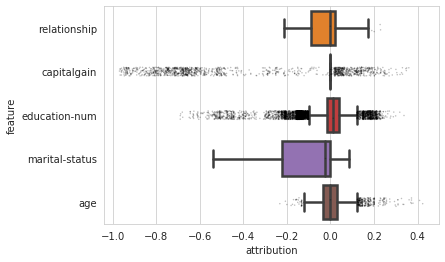

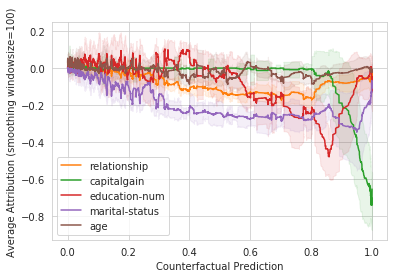

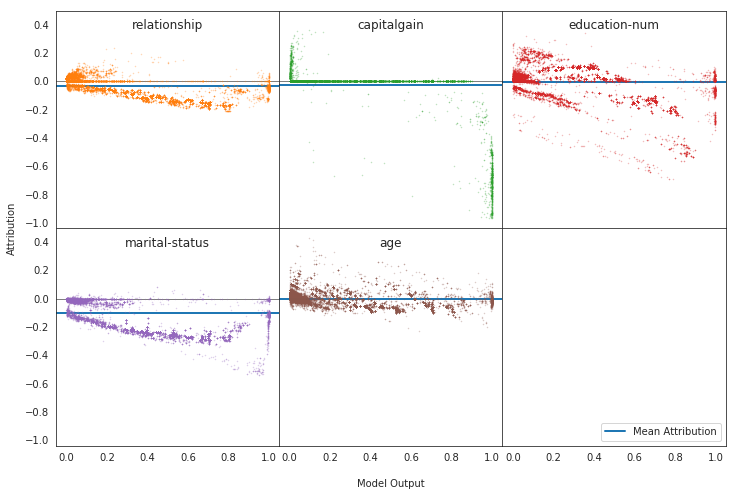

In [8]:
model_fn = lambda input_df: model.predict_proba(input_df)[:, 1]

cf_sample = x_test
phi_0, phi = multi_shapley_values(model_fn, model_input, cf_sample)

phi_0_marginal, phi_marginal = phi_0, phi # save

display(phi.mean().to_frame().T.style.set_caption('Mean Attributions'))

result_plots(phi_0, phi, fig_path=figures_dir, figname='adult_marginal')

# Compare against higher scoring predictions

## Score between 0.2 and 0.4

There are 2669 rows with prediction between 0.2 and 0.4
pre-computing payout functions...


100%|██████████| 2669/2669 [00:00<00:00, 10834.45it/s]


computing shapley values...


100%|██████████| 2669/2669 [00:02<00:00, 1235.79it/s]


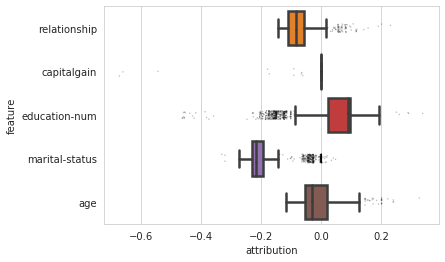

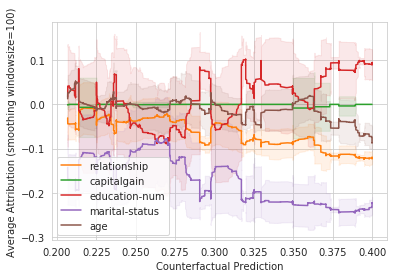

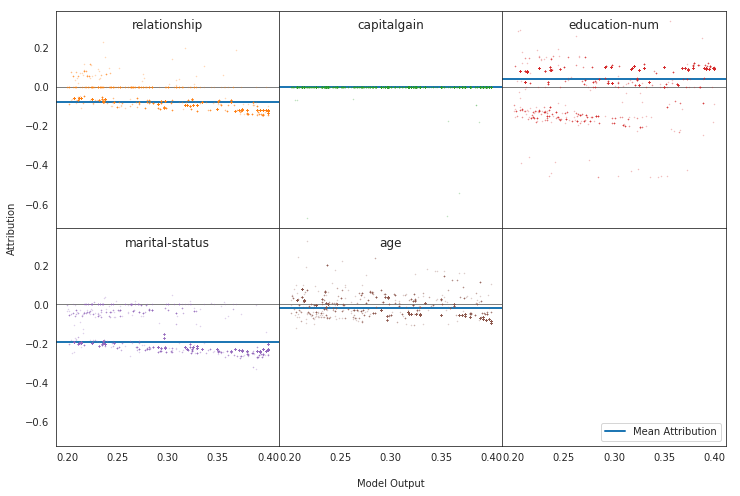

,relationship,capitalgain,education-num,marital-status,age
mean,-0.0753226,-0.000976225,0.0425364,-0.191242,-0.0186304
std,0.0453153,0.0218444,0.0952939,0.0718368,0.0507144


In [9]:
idx = y_hat_test[y_hat_test.between(0.2, 0.4)].index
high_pred_inputs = x_test.loc[idx]
high_pred_rows = pd.concat([high_pred_inputs, y_hat_test.loc[idx]], axis=1)
print(f'There are {high_pred_rows.shape[0]} rows with prediction between 0.2 and 0.4')
# display(high_pred_rows.sample(5, random_state=0))

phi_0, phi = multi_shapley_values(model_fn, model_input, high_pred_inputs)

result_plots(phi_0, phi, fig_path=figures_dir, figname='adult_0_2_0_4')


display(phi.agg(['mean','std']).style.set_caption('Mean Attributions'))

## Score > 0.5
If what we really care about is why this point didn't pass the 0.5 threshold, we can compare to the counterfactual "higher than the threshold" by sampling games only where the scores are greater than 0.5.

There are 3163 rows with prediction above 0.5
pre-computing payout functions...


100%|██████████| 3163/3163 [00:00<00:00, 12524.72it/s]


computing shapley values...


100%|██████████| 3163/3163 [00:02<00:00, 1243.08it/s]


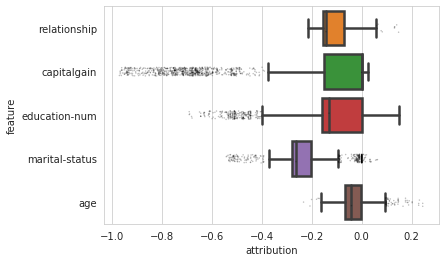

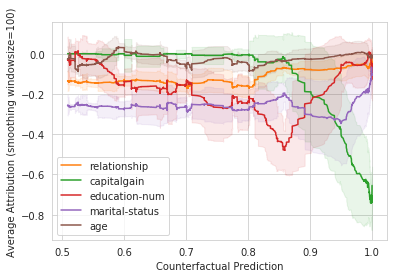

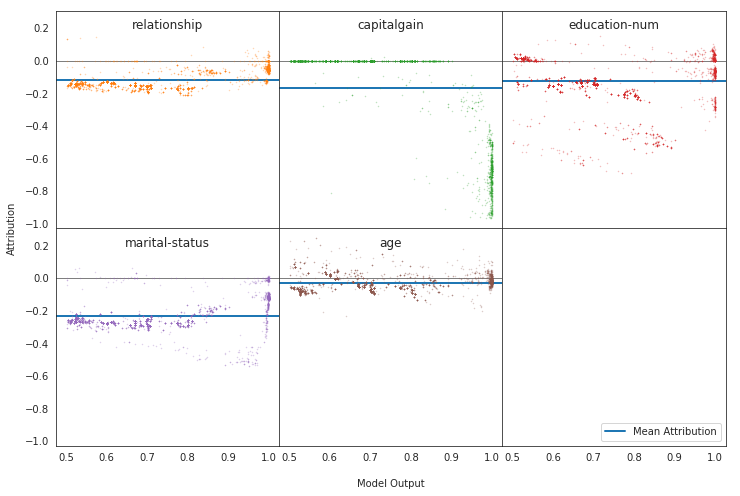

,relationship,capitalgain,education-num,marital-status,age
0,-0.119013,-0.165092,-0.126081,-0.23276,-0.032406


In [10]:
idx = y_hat_test[y_hat_test.gt(0.5)].index
high_pred_inputs = x_test.loc[idx]
high_pred_rows = pd.concat([high_pred_inputs, y_hat_test.loc[idx]], axis=1)
print(f'There are {high_pred_rows.shape[0]} rows with prediction above 0.5')
# display(high_pred_rows.sample(5, random_state=0))

phi_0, phi = multi_shapley_values(model_fn, model_input, high_pred_inputs)

result_plots(phi_0, phi, fig_path=figures_dir, figname='adult_0_5')

display(phi.mean().to_frame().T.style.set_caption('Mean Attributions'))

## Score 0.99+
Here we can see that to get into the very high score range, this point would need a nonzero capital gain, rather than any other features. This shows that the model will probably not give a 0.99+ score unless it sees something else in the capitalgain field.

There are 643 rows with prediction 0.99+
pre-computing payout functions...


100%|██████████| 643/643 [00:00<00:00, 84237.18it/s]


computing shapley values...


100%|██████████| 643/643 [00:00<00:00, 1149.74it/s]


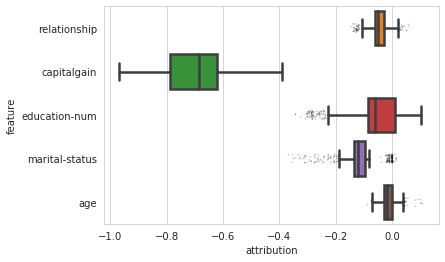

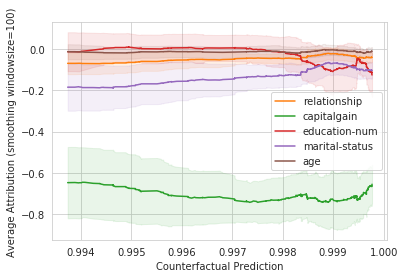

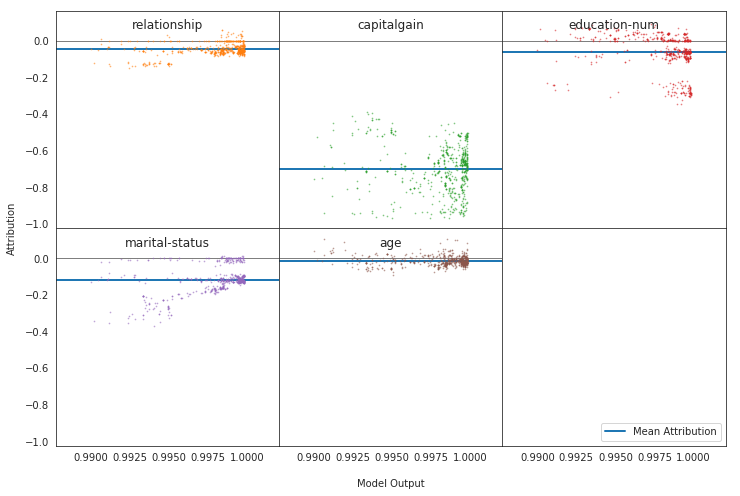

,relationship,capitalgain,education-num,marital-status,age
mean,-0.0447328,-0.699664,-0.0617191,-0.1169,-0.0137559
std,0.0340858,0.126677,0.0993996,0.072384,0.0258366


In [11]:
idx = y_hat_test[y_hat_test >= 0.99].index
high_pred_inputs = x_test.loc[idx]
high_pred_rows = pd.concat([high_pred_inputs, y_hat_test.loc[idx]], axis=1)
print(f'There are {high_pred_rows.shape[0]} rows with prediction 0.99+')
# display(high_pred_rows.sample(5, random_state=0))

phi_0, phi = multi_shapley_values(model_fn, model_input, high_pred_inputs)
result_plots(phi_0, phi, fig_path=figures_dir, figname='adult_0_99')
display(phi.agg(['mean', 'std']).style.set_caption('Mean Attributions'))

In [12]:
# side-note: capitalgain is almost always zero
x_test['capitalgain'].eq(0).mean()

0.9187396351575456

# Compare against uniform distribution
Here is an example of how when one feature is very predictive but almost always missing, the uniform distribution can really cause that feature to dominate. Identifying this sensitivity can definitely be helpful, though, and it is very faithful to the model. Intuitively, the `capitalgain` feature is the most important to the model when we ignore its rarity in the data.

pre-computing payout functions...


100%|██████████| 16281/16281 [00:01<00:00, 11207.46it/s]


computing shapley values...


100%|██████████| 16281/16281 [00:14<00:00, 1121.35it/s]


,relationship,capitalgain,education-num,marital-status,age
0,0.0067907,-0.79404,0.0245571,-0.0332819,0.0387671


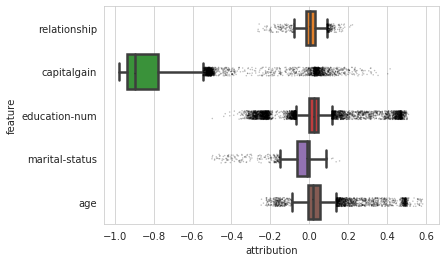

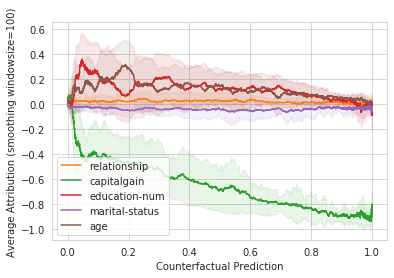

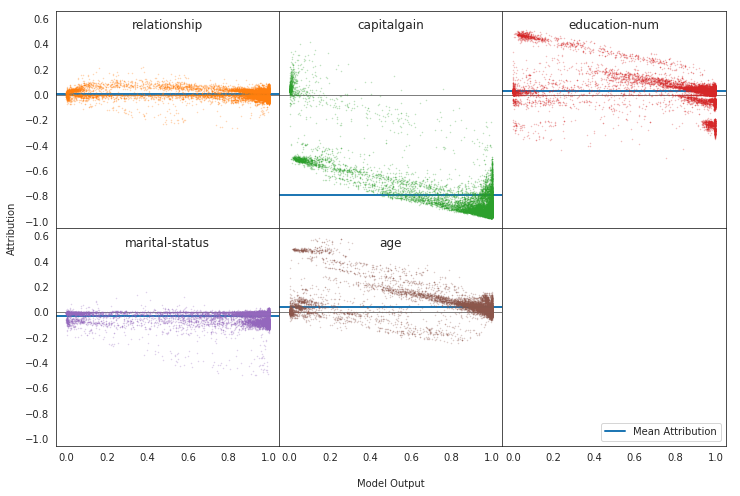

In [14]:
# sample randomly in each column from possible ranges
sample_dict = dict()
rng = np.random.RandomState(0)
for column_name, column in x_test.iteritems():
    if column.dtype.name == 'category':
        sample_dict[column_name] = rng.choice(column.unique(), cf_sample.shape[0])
    else:
        sample_dict[column_name] = rng.choice(np.linspace(*column.agg(['min','max']), num=10_000), cf_sample.shape[0])

# build a dataframe with matching datatypes
uniform_sample_df = pd.DataFrame(sample_dict)
for column_name in x_test:
    uniform_sample_df[column_name] = uniform_sample_df[column_name].astype(x_test[column_name].dtype)

phi_0, phi = multi_shapley_values(model_fn, model_input, uniform_sample_df)
phi_0_unif, phi_unif = phi_0, phi # save

display(phi.mean().to_frame().T.style.set_caption('Mean Attributions'))

result_plots(phi_0, phi, fig_path=figures_dir, figname='adult_uniform')

## Irrelevant counterfactuals

In [15]:
x_test['capitalgain'].gt(0).mean()

0.0812603648424544

In [16]:
y_hat_test.gt(.5).mean()

0.1942755359007432

In [17]:
x_test.loc[y_hat_test.gt(.5), 'capitalgain'].gt(0).mean()

0.25608599430920015

Text(0.5, 1.0, 'Real Distribution of Capitalgain vs. Uniform')

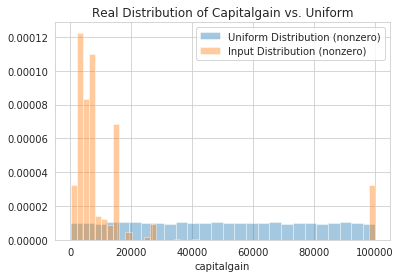

In [18]:
nonzero_real_capitalgain = x_test['capitalgain'].replace(0, np.nan).dropna()
nonzero_uniform_capitalgain = uniform_sample_df['capitalgain'].replace(0, np.nan).dropna()
sns.distplot(nonzero_uniform_capitalgain, kde=False, norm_hist=True, label='Uniform Distribution (nonzero)')
sns.distplot(nonzero_real_capitalgain, kde=False, norm_hist=True, label='Input Distribution (nonzero)')
plt.legend()
plt.title('Real Distribution of Capitalgain vs. Uniform')

In [19]:
nonzero_real_capitalgain.between(45_000, 95_000, inclusive=True).mean()

0.0

In [20]:
nonzero_real_capitalgain.between(45_000, 95_000, inclusive=True).sum()

0

In [21]:
nonzero_real_capitalgain[nonzero_real_capitalgain.between(30_000, 100_000, inclusive=True)].value_counts()

99999.0    85
34095.0     1
41310.0     1
Name: capitalgain, dtype: int64

In [22]:
nonzero_uniform_capitalgain.between(45_000, 95_000, inclusive=True).mean()

0.4974815724815725

# Joint marginal
If the dataset has high correlations, we might consider building a joint-marginal distribution. Let's look at the correlation matrix.

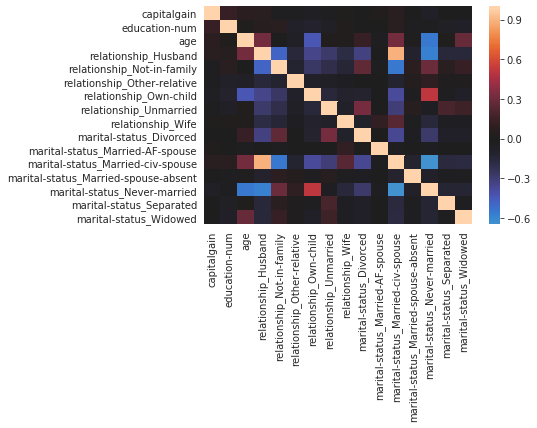

In [23]:
sns.heatmap(pd.get_dummies(x_test).corr(), center=0)

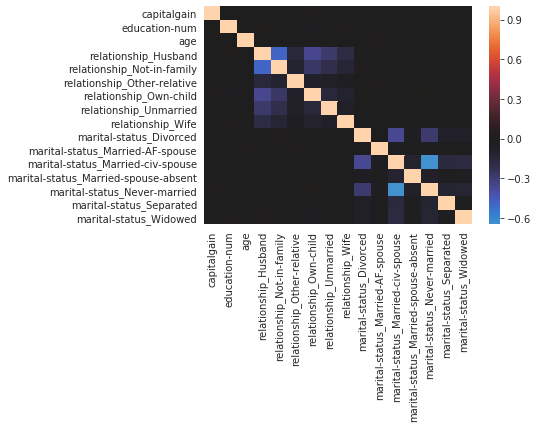

In [24]:
# sample randomly in each column separately
sample_dict = dict()
rng = np.random.RandomState(0)
for column_name, column in x_test.iteritems():
    sample_dict[column_name] = rng.choice(column.values, cf_sample.shape[0])

# build a dataframe with matching datatypes
jm_sample_df = pd.DataFrame(sample_dict)
for column_name in x_test:
    jm_sample_df[column_name] = jm_sample_df[column_name].astype(x_test[column_name].dtype)

# show how correlation has been mitigated
sns.heatmap(pd.get_dummies(jm_sample_df).corr(), center=0)

In [41]:
phi_0, phi = multi_shapley_values(model_fn, model_input, jm_sample_df)
phi_0_jm, phi_jm = phi_0, phi # save


display(phi.mean().to_frame().T.style.set_caption('Mean Attributions'))

pre-computing payout functions...


100%|██████████| 16281/16281 [00:01<00:00, 10363.24it/s]


computing shapley values...


100%|██████████| 16281/16281 [00:14<00:00, 1162.25it/s]


,relationship,capitalgain,education-num,marital-status,age
0,-0.0159395,-0.031804,-0.00818812,-0.0847748,0.014106


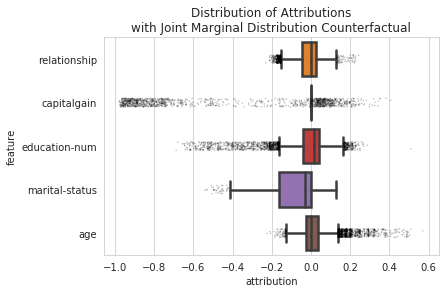

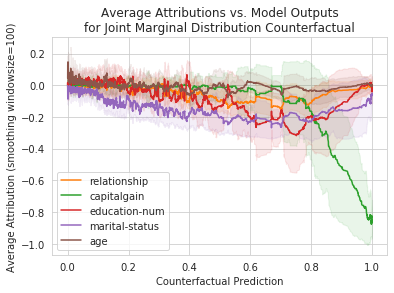

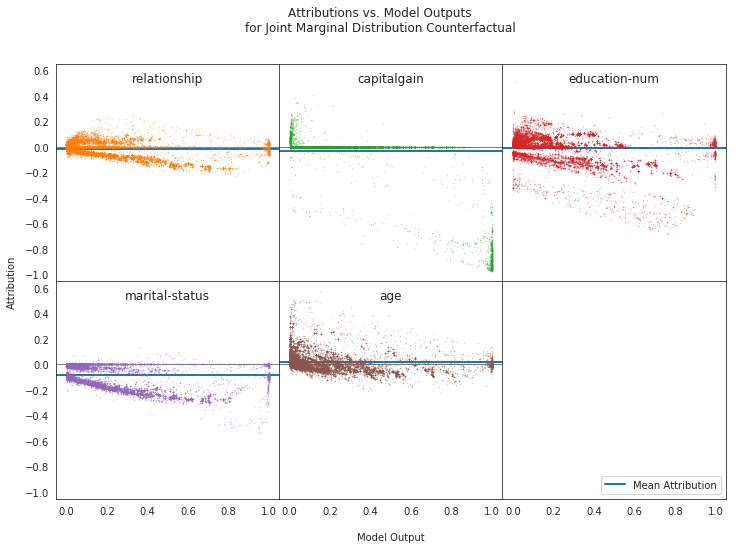

In [42]:
result_plots(phi_0, phi, 'Joint Marginal Distribution', fig_path=figures_dir, figname='adult_joint_marginal')

In [43]:
pd.DataFrame([phi_marginal.mean().values / np.abs(phi_marginal.mean().values).sum(), 
              phi.mean().values / np.abs(phi.mean().values).sum()], 
             index=['Marginal (normalized)', 'Joint Marginal (normalized)'],
             columns=x_test.columns)

,relationship,capitalgain,education-num,marital-status,age
Marginal (normalized),-0.201039,-0.167875,-0.041186,-0.587179,-0.002721
Joint Marginal (normalized),-0.102960,-0.205436,-0.052891,-0.547597,0.091117


# Clustering

We'll start by seeing how big groups are when clustered by vanilla k-means.

In [28]:
phi = phi_marginal
k = 5
kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(phi)
cluster_ids = kmeans.predict(phi) + 1

print('Cluster ranges:')
pd.Series(model_fn(x_test)).groupby(cluster_ids).agg(['min', 'max']).style.format('{:.3f}')

Cluster ranges:


,min,max
1,0.123,0.983
2,0.000,0.718
3,0.096,1.000
4,0.000,0.974
5,0.028,0.901


In [29]:
# project to 2-dimension via PCA to visualize 
pca = sklearn.decomposition.PCA(n_components=2).fit(phi)
two_dim_phi = pd.DataFrame(pca.transform(phi), columns=['pca_1', 'pca_2'])
print(f'Explained variance: {pca.explained_variance_ratio_.sum():.2f}')
pd.DataFrame(pca.components_, columns=phi.columns, index=['pca_1', 'pca_2'])

Explained variance: 0.74


,relationship,capitalgain,education-num,marital-status,age
pca_1,-0.065412,-0.980763,-0.129087,-0.128365,-0.026164
pca_2,-0.479486,0.159824,-0.101808,-0.841407,-0.161924


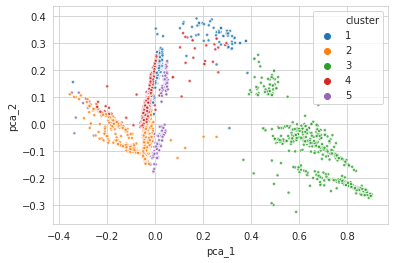

In [30]:
# plot results
two_dim_phi['cluster'] = cluster_ids
sns.scatterplot(x='pca_1', y='pca_2', hue='cluster', palette=sns.color_palette()[:k], data=two_dim_phi, s=10, alpha=0.8)
plt.savefig(figures_dir / 'adult_pca_cluster.png', bbox_inches='tight')
plt.show()

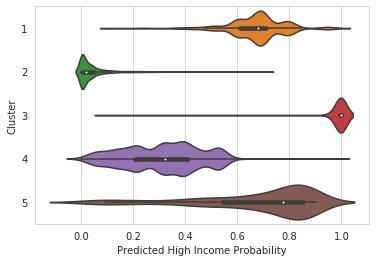

In [31]:
pred_by_cluster = pd.DataFrame({'Predicted High Income Probability': y_hat_test, 'Cluster': cluster_ids}).sort_values(by='Cluster')
pred_by_cluster['Cluster'] = pred_by_cluster['Cluster'].astype('category')
sns.violinplot(x='Predicted High Income Probability', y='Cluster', data=pred_by_cluster, scale='width', palette=sns.color_palette()[1:])

# pred_by_cluster = pd.DataFrame(dict(counterfactual_pred=model_fn(x_test), cluster=[f'cluster_{i}' for i in cluster_ids]))
# sns.violinplot(x='counterfactual_pred', y='cluster', data=pred_by_cluster, scale='width')
# plt.title('Model prediction ranges for each cluster')
plt.savefig(figures_dir / 'adult_cluster_violin.png', bbox_inches='tight')
plt.show()

In [32]:
def ci_95(series):
    return 1.96 * series.std() / np.sqrt(series.shape[0])

# display details of clusters
grouped = phi.groupby(two_dim_phi['cluster'])
groupwise_explanations = grouped.agg(['mean', 'std', ci_95]).round(4)
groupwise_explanations['total_delta'] = grouped.mean().sum(axis=1)
groupwise_explanations.insert(0, 'cluster_size', grouped.size().div(phi.shape[0]).apply(lambda x: f'{x:.1%}'))
groupwise_explanations.insert(0, 'avg_pred', phi_0.groupby(two_dim_phi['cluster']).mean().round(2))
print('model pred:', model_fn(model_input))
display(groupwise_explanations)

model pred: [0.06132481]


avg_pred cluster_size relationship                 capitalgain  \
                                      mean     std   ci_95        mean   
cluster                                                                  
1           0.83        10.2%      -0.1513  0.0261  0.0013     -0.0098   
2           0.82        55.3%       0.0147  0.0216  0.0004      0.0045   
3           0.83         4.4%      -0.0414  0.0386  0.0028     -0.7003   
4           0.81        28.0%      -0.0904  0.0378  0.0011     -0.0002   
5           0.82         2.1%      -0.0365  0.0608  0.0065      0.0066   

                        education-num                 marital-status          \
            std   ci_95          mean     std   ci_95           mean     std   
cluster                                                                        
1        0.0510  0.0025       -0.1460  0.0460  0.0022        -0.2821  0.0498   
2        0.0256  0.0005       -0.0040  0.0492  0.0010        -0.0118  0.0252   
3        0.1302  0.0095       -0.0597  0.1025  0.0075        -0.1151  0.0805   
4        0.0210  0.0006        0.0795  0.0587  0.0017        -0.2127  0.0440   
5        0.0456  0.0049       -0.4717  0.0835  0.0090        -0.1436  0.1068   

                    age                 total_delta  
          ci_95    mean     std   ci_95              
cluster                                              
1        0.0024 -0.0236  0.0595  0.0029   -0.612739  
2        0.0005  0.0158  0.0360  0.0007    0.019162  
3        0.0059 -0.0078  0.0438  0.0032   -0.924335  
4        0.0013 -0.0256  0.0497  0.0014   -0.249394  
5        0.0115  0.0338  0.1072  0.0115   -0.611400

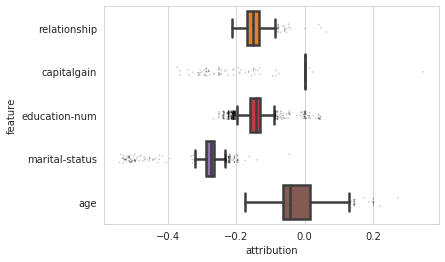

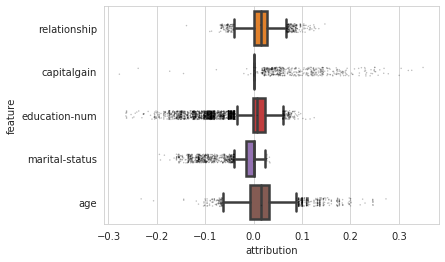

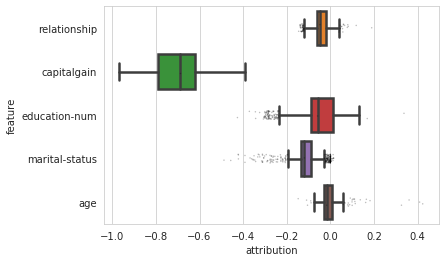

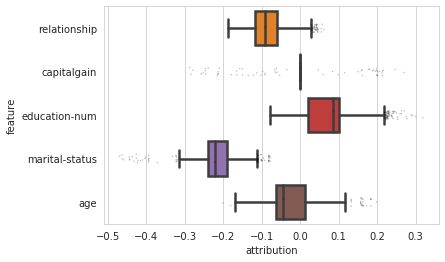

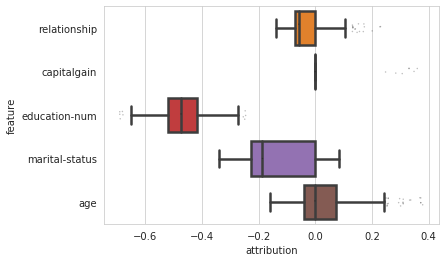

In [33]:
for i, group in grouped:
    plot_phi(group)
#     plt.title(f'Attributions vs cluster {i} ({group.shape[0]/phi.shape[0]:.1%} of data, avg_pred={groupwise_explanations.loc[i, "avg_pred"][0]:.2f})')
#     plt.xlim(-1, 1)
    plt.savefig(figures_dir / f'adult_cluster_{i}.png', bbox_inches='tight')
    plt.show()

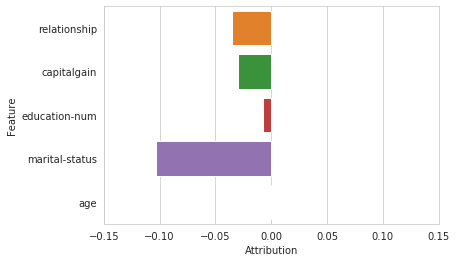

In [34]:
# mean of marginal attributions for comparison
sns.barplot(x=0, y='index', data=pd.Series(phi_marginal.mean(), index=phi_marginal.columns).reset_index(), palette=sns.color_palette()[1:])
plt.xlim(-.15, .15)
plt.ylabel('Feature')
plt.xlabel('Attribution')
plt.title(None)
f.savefig(figures_dir / 'adult_shap_values_barplot.png', bbox_inches='tight')
plt.show()

# Cluster explanations:
0. some points have relationship, education, and marital status that cause better scores (score ~.67)
1. many points are similar, scoring about the same
2. a small slice of points have much better capitalgain, achieving almost perfect scores (score ~.99)
3. some points have worse education, but better marital status and relationship, achieving higher but still low scores (score ~.32)

# Takeaways
Our individual could get a higher score in a number of ways. An almost-perfect score could come from improving capitalgain, and a moderate score from improving marital status, education, and relationship.

# Confidence Intervals

In [35]:
phi_0.groupby(two_dim_phi['cluster']).apply(ci_95)

,phi_0
cluster,
1,0.014272
2,0.006445
3,0.022136
4,0.009116
5,0.032503


In [36]:
marg_table = phi_marginal.agg(['mean', 'std', ci_95])
marg_table.insert(0, 'avg_pred', phi_0_marginal.agg(['mean', 'std', ci_95]))

jm_table = phi_jm.agg(['mean', 'std', ci_95])
jm_table.insert(0, 'avg_pred', phi_0_jm.agg(['mean', 'std', ci_95]))

unif_table = phi_unif.agg(['mean', 'std', ci_95])
unif_table.insert(0, 'avg_pred', phi_0_unif.agg(['mean', 'std', ci_95]))

for table in (marg_table, jm_table, unif_table):
    display(table.round(4))

,avg_pred,relationship,capitalgain,education-num,marital-status,age
mean,0.2366,-0.0352,-0.0294,-0.0072,-0.1029,-0.0005
std,0.2858,0.0669,0.1497,0.1084,0.1138,0.0499
ci_95,0.0044,0.0010,0.0023,0.0017,0.0017,0.0008


,avg_pred,relationship,capitalgain,education-num,marital-status,age
mean,0.8185,0.0068,-0.7940,0.0246,-0.0333,0.0388
std,0.3105,0.0339,0.2530,0.1266,0.0464,0.0911
ci_95,0.0048,0.0005,0.0039,0.0019,0.0007,0.0014


,avg_pred,relationship,capitalgain,education-num,marital-status,age
mean,0.8185,0.0068,-0.7940,0.0246,-0.0333,0.0388
std,0.3105,0.0339,0.2530,0.1266,0.0464,0.0911
ci_95,0.0048,0.0005,0.0039,0.0019,0.0007,0.0014


In [37]:
# get the quantile of the average uniform prediction
(y_hat_test < phi_0_unif.mean()[0]).mean()

0.943430993182237

In [38]:
phi_marginal.mean()

relationship     -0.035229
capitalgain      -0.029418
education-num    -0.007217
marital-status   -0.102895
age              -0.000477
dtype: float64

In [39]:
phi_marginal.sample(30, random_state=0).mean()

relationship     -0.037594
capitalgain      -0.046953
education-num    -0.009325
marital-status   -0.099987
age               0.000550
dtype: float64

In [40]:
phi_marginal.sample(30, random_state=0).apply(ci_95)

relationship      0.026460
capitalgain       0.073724
education-num     0.026848
marital-status    0.041542
age               0.016876
dtype: float64